In [1]:
from stable_baselines3 import PPO

from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper, DiscreteActionWrapper
from citylearn.data import DataSet

from art.estimators.classification import PyTorchClassifier as classifier
from art.attacks.evasion import AutoConjugateGradient as ACG

from torch.nn import CrossEntropyLoss

from tqdm import tqdm

import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
dataset_name = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [3]:
schema = DataSet.get_schema(dataset_name)

In [4]:
def make_discrete_env(schema, action_bins: int = 10, bldg: list = ['Building_1'], single_agent: bool = True, seed:int = 0):
    """Because ART's attacks are designed for supervised learning they one work with ANNs with a single label or head, using multiple buildings adds an action/head for each"""
    env = CityLearnEnv(schema, 
        central_agent=single_agent, 
        buildings=bldg, 
        random_seed=seed)
    #Because ART attacks are made for classification tasks we need a discrete action space 
    env = DiscreteActionWrapper(env, bin_sizes=[{'electrical_storage':action_bins}])
    #Calendar observations are periodically normalized, everything else is min/max normalized 
    env = NormalizedObservationWrapper(env)
    #provides an interface for SB3
    env = StableBaselines3Wrapper(env)
    return env

Train victim agent (Python: Launch Tensorboard)

In [5]:
agent_name = f'Models/Victim/default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_power_cost_rwd_300'

agent = PPO.load(path=agent_name)
print('Model loaded from storage')

Model loaded from storage


In [6]:
building = list(schema['buildings'].keys())[0] #the first building from the schema's building keys
bins = agent.action_space[0].n
env = make_discrete_env(schema=schema, 
                        bldg=[building], 
                        action_bins=bins,
                        seed=42)

In [7]:
def format_kpis(env):
    """displays the KPIs from the evnironment's most recent timestep.
    This function can be called after an agent runs in a test env to evaluate performance"""

    kpis = env.evaluate().pivot(index='cost_function', columns='name', values='value')
    kpis = kpis.dropna(how='all')
    kpis = kpis['District']
    kpis = kpis[kpis != 0]
    return kpis

In [8]:
def eval_agent(env, agent):
    """displays the KPIs for each building and district
    ref quickstart"""
    obs_list = []
    a_list = []

    observations = env.reset()

    while not env.done:
        obs_list.append(observations)
        actions, _ = agent.predict(observations, deterministic=True)
        a_list.append(actions)
        observations, _, _, _ = env.step(actions)
    #obs_list.append(observations) #no action take for this observation
    
    return format_kpis(env), np.array(obs_list), np.array(a_list)

In [9]:
def extract_actor(agent):
    """Extracts the policy network from and SB3 actor critic algorithm as a pytorch seuqential network"""
    from copy import deepcopy
    policy_net = deepcopy(agent.policy.mlp_extractor.policy_net) #copies shared net rather than referencing
    policy_net.add_module('actions', agent.policy.action_net)
    return policy_net

In [10]:
def get_feature_permutations(agent, observations:np.array, actions: np.array, FeaturePermuation_kwargs: dict=None) -> np.array:
    from captum.attr import FeaturePermutation
    import torch

    tensor_obs = torch.from_numpy(observations).type(torch.FloatTensor).to('cuda')
    actor = extract_actor(agent)
    fp = FeaturePermutation(actor)
    attr = fp.attribute(tensor_obs, 
                    target=actions.flatten().tolist())
    attr = attr.detach().cpu().numpy()

    return np.mean(attr, axis=0)

Unperturbed agent performance

Compared to the agent trained with the default reward (20 bins), the results are comparable though they surpass eachother in different areas. While being significantly cheaper, it's significantly worse for consuption and peaking. This makes sense since price rather than net consumption is used in the rweard function.

The reward is a proportional to cost and the SOC, where the max value is the current cost (if SOC is 0%) and the min is double that (when the SOC is 100%). the cost is a function of net consumption and pricing.

In [11]:
baseline_kpis, baseline_obs, baseline_a = eval_agent(env,agent)
display(baseline_kpis)

cost_function
annual_peak_average                      1.235401
carbon_emissions_total                   1.054337
cost_total                               0.916717
daily_one_minus_load_factor_average      0.992094
daily_peak_average                       1.255400
electricity_consumption_total            1.061959
monthly_one_minus_load_factor_average    1.006374
ramping_average                          1.866068
zero_net_energy                          1.083838
Name: District, dtype: float64

We'll prepare an index with our feature names, since CityLearn does not name them properly

In [12]:
index = env.observation_names[0]
#add second index for periodic features
for i in [1,3,5]:
    index.insert(i, index[i-1] + '_cos')
#add suffix for other periodic features
for i in [0,2,4]:
    index[i] += '_sin'

All 3 agents prioritize the hour and SOC, however this model relies more evenly amoung all three. Additionally it values the non-shfitable load feature the most, in terms of it's rank and value. 

In [13]:
attributions = get_feature_permutations(agent, baseline_obs, baseline_a)
attributions = pd.Series(attributions, index=index)
display(attributions.sort_values(ascending=False))

electricity_pricing_predicted_6h              1.671780
day_type_sin                                  1.395455
day_type_cos                                  1.252541
electrical_storage_soc                        1.196406
month_sin                                     1.074718
direct_solar_irradiance_predicted_12h         0.729068
direct_solar_irradiance_predicted_6h          0.678166
electricity_pricing                           0.633921
electricity_pricing_predicted_24h             0.625126
non_shiftable_load                            0.597508
direct_solar_irradiance_predicted_24h         0.580318
direct_solar_irradiance                       0.488972
hour_cos                                      0.422848
diffuse_solar_irradiance_predicted_24h        0.421385
electricity_pricing_predicted_12h             0.401999
diffuse_solar_irradiance_predicted_6h         0.362134
diffuse_solar_irradiance                      0.320167
carbon_intensity                              0.301511
diffuse_so

In [14]:
df_baseline_obs = pd.DataFrame(baseline_obs, columns=index)

<Axes: >

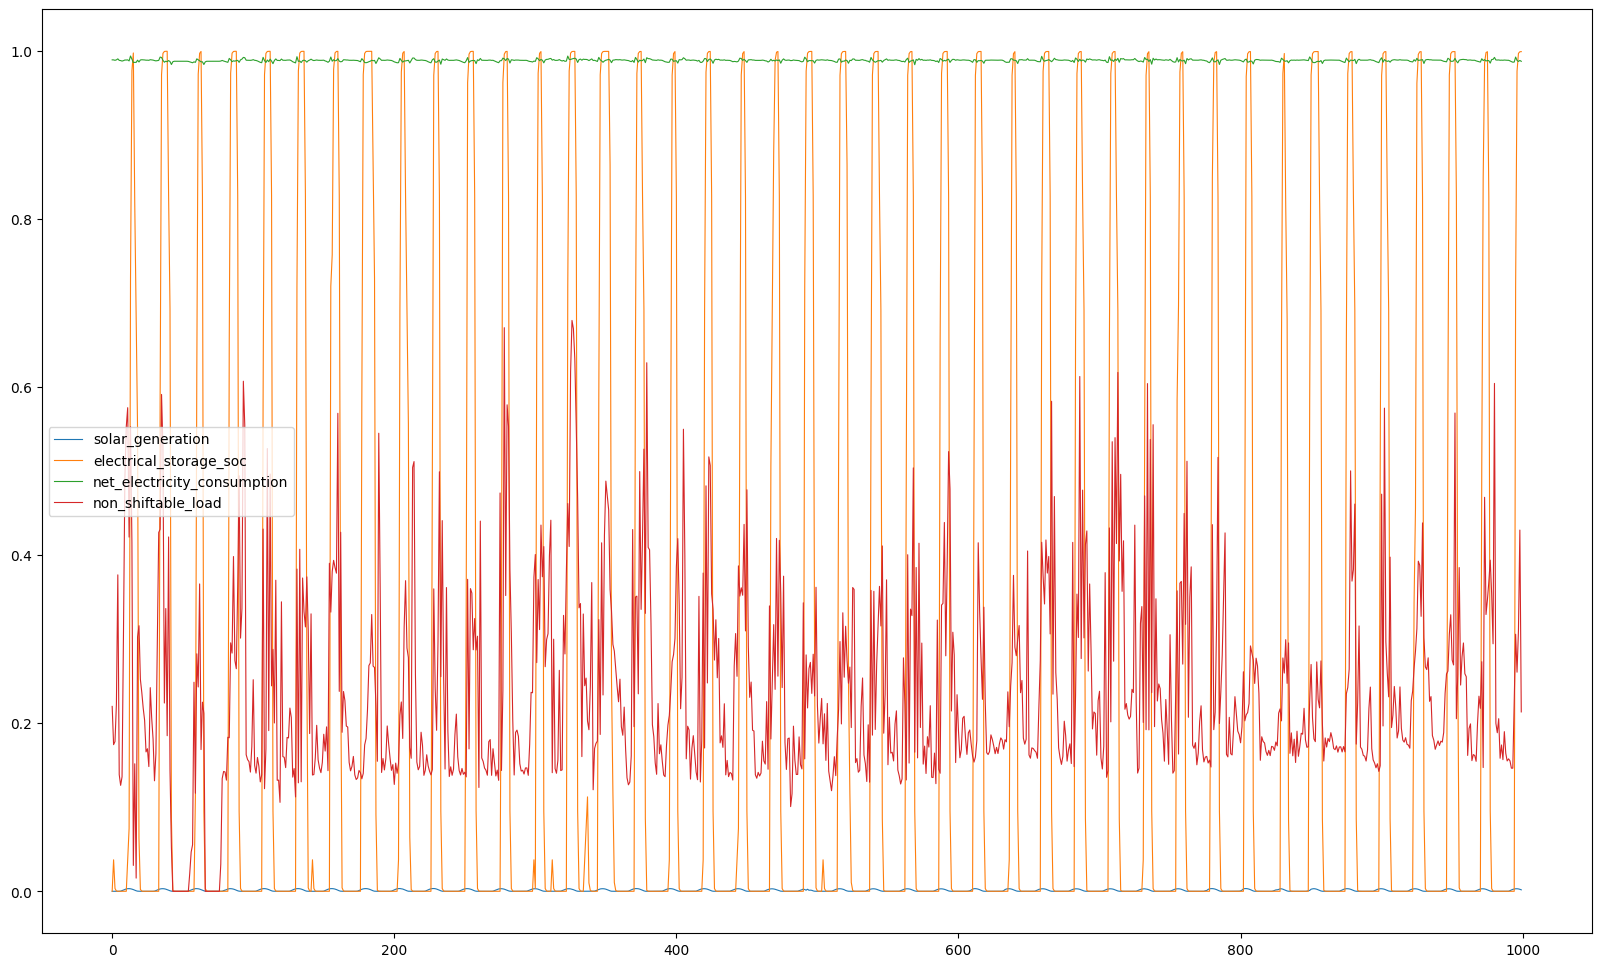

In [15]:
df_baseline_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

In [16]:
def eval_rand_attack(agent, env, eps=0.3):
    """displays the KPIs for each building and district withc random noise in the observations
    ref quickstart"""
    obs_list = []
    asr = 0

    observations = env.reset()
    
    while not env.done:
        obs_list.append(observations)
        noisey_obs = observations + np.random.rand(*observations.shape)*eps
        a_adv, _ = agent.predict(noisey_obs, deterministic=True)
        actions, _ = agent.predict(observations, deterministic=True)
        if a_adv!=actions: #check if the perturbation changed the agent's action
            asr+=1
        observations, _, _, _ = env.step(a_adv)
    obs_list.append(observations)

    asr/=env.time_steps
    print(f'The Adversarial success rate is: {asr}')
    return format_kpis(env), np.array(obs_list)

Model performance while observations are perturbed by random noise [0,1). Note that all the observation values are normalized to [0,1]

In [17]:
rand_kpis, rand_obs = eval_rand_attack(agent, env, eps=0.3)

The Adversarial success rate is: 0.5787671232876712


Here's the regret for the random attack:

In [18]:
display(baseline_kpis - rand_kpis)

cost_function
annual_peak_average                     -0.150477
carbon_emissions_total                  -0.015311
cost_total                              -0.014653
daily_one_minus_load_factor_average     -0.001121
daily_peak_average                      -0.075707
electricity_consumption_total           -0.013792
monthly_one_minus_load_factor_average   -0.019256
ramping_average                         -0.056154
zero_net_energy                         -0.001291
Name: District, dtype: float64

In [19]:
df_rand_obs = pd.DataFrame(rand_obs, columns=index)

<Axes: >

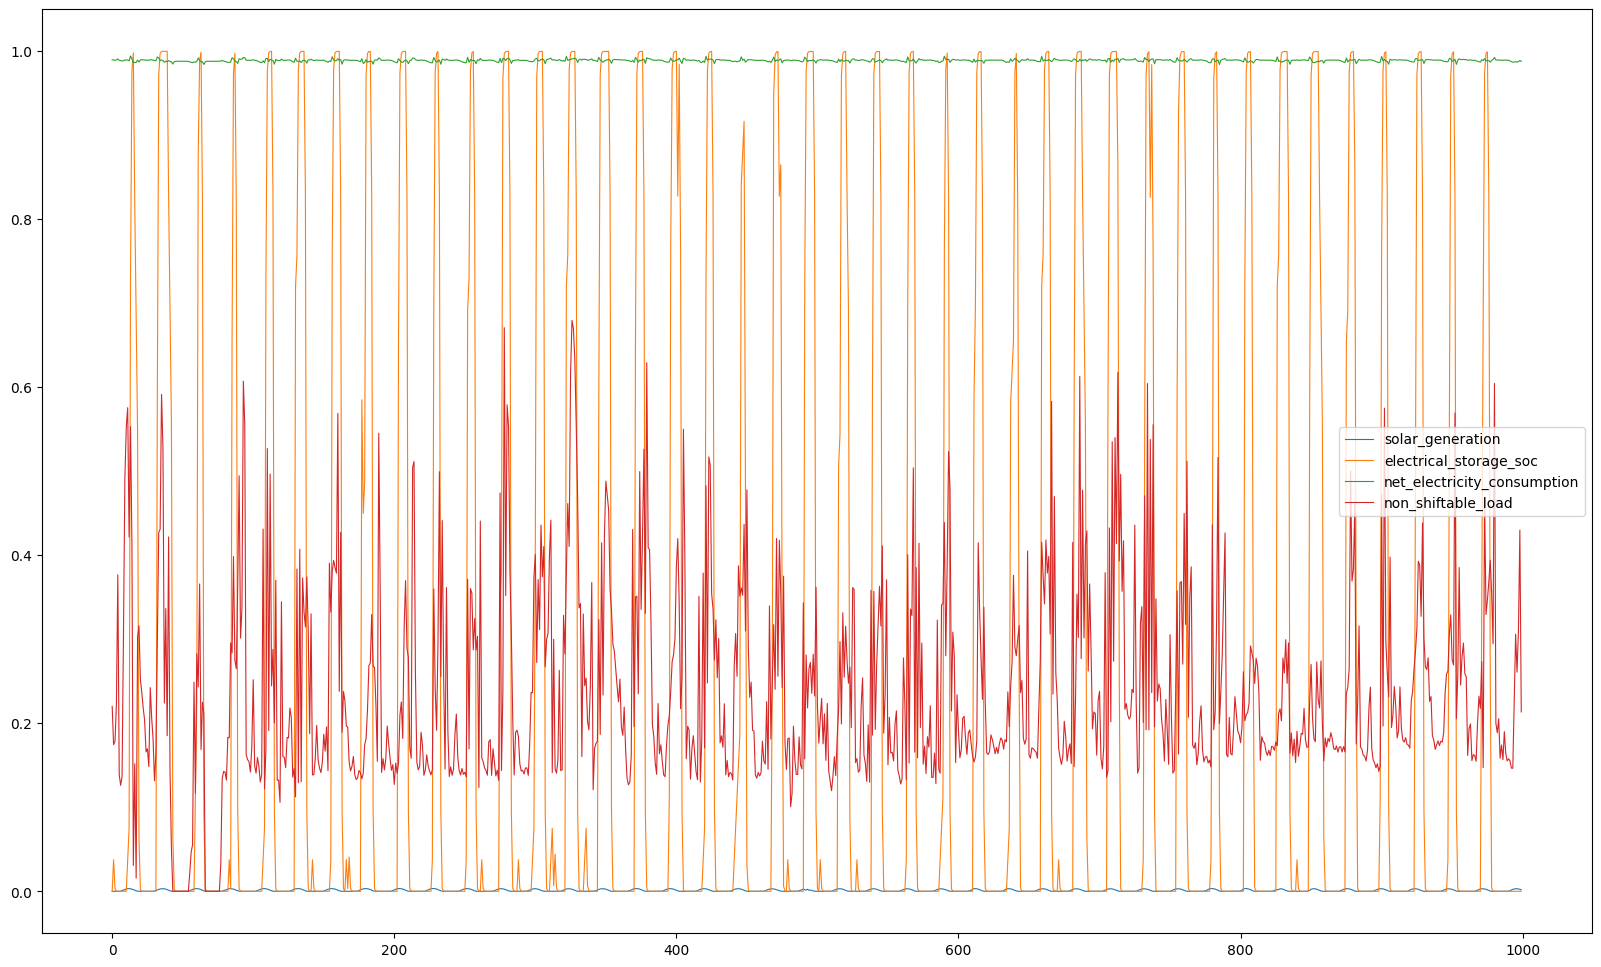

In [20]:
df_rand_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]][:1000].plot.line(figsize=(20,12), lw=0.8)

Define our gradient based attack:

In [21]:
def extract_actor(agent):
    """Extracts the policy network from and SB3 actor critic algorithm as a pytorch seuqential network"""
    from copy import deepcopy
    policy_net = deepcopy(agent.policy.mlp_extractor.policy_net) #copies shared net rather than referencing
    policy_net.add_module('actions', agent.policy.action_net)
    return policy_net

In [22]:
def define_attack(agent, env, ART_atk, loss_fn=CrossEntropyLoss(), **kwargs):
    """returns an ART attack function based on the input gym enviornment, SB3 Agent and ART attack class"""
    
    agent_policy = extract_actor(agent)

    victim_policy = classifier(
        model=agent_policy,
        loss=loss_fn, 
        nb_classes=env.action_space[0].n,
        input_shape=agent.observation_space.shape,
        device_type='gpu'
        )

    return ART_atk(estimator=victim_policy, verbose=False, **kwargs)

In [23]:
def eval_untargeted_attack(agent, env, atk, time_steps:int=None, mask:list=None):
    """Evaluates an SB3 agent subject to untargeted observation perturbations generated by an ART evasion attack"""
    obs_list = []
    asr = 0

    observations = env.reset()
    #failed_adv_exs = 0
    if time_steps is None:
        time_steps = env.time_steps - 1
    if mask is None:
        mask=np.ones(agent.observation_space.shape[0]) #1 for all features

    for _ in tqdm(range(time_steps)):

        obs_list.append(observations)

        adv_obs = np.expand_dims(observations, axis=0) #ART atks expect a 2d array
        #would using the true label/action imporve the asr? it would hurt adversarial training: https://arxiv.org/abs/1611.01236
        adv_obs = atk.generate(adv_obs, mask=mask)
        adv_obs = np.squeeze(adv_obs) #CityLearn envs expect a 1d array
        
        a_adv, _ = agent.predict(adv_obs, deterministic=True)
        #actions, _ = agent.predict(observations, deterministic=True)
        if not np.array_equal(adv_obs, observations): #check if an adversarial example was crafted
            asr+=1
        #if a_adv!=actions: #check if the perturbation changed the agent's action
        #    asr+=1
        #elif np.array_equal(adv_obs, observations): #when the victim's action is unchanged, check if an adv observation was crafted
        #    failed_adv_exs+=1
        observations, _, _, _ = env.step(a_adv)

        if env.done:
            break
    
    obs_list.append(observations)
    asr/=time_steps
    print(f'The Adversarial success rate is: {asr}')
    #print(f'{failed_adv_exs} adversarial examples were produced but failed to change the victim\'s action')
    return format_kpis(env), np.array(obs_list)

In [24]:
ACG_parameters = dict(
    loss_type='difference_logits_ratio', 
    batch_size=1,
    eps=0.0125, #default 0.3,
    eps_step=0.007, #0.1, default ration: eps:3*eps_step
    nb_random_init=5, #5, lower values speed crafting
    max_iter=100, #iterations per restart
    norm='inf', #->l2 ->l1 most restrictive 
)
attack = define_attack(agent, env, ACG, **ACG_parameters)

Before attacking the victim, we must understand what we are perturbing. So we need to see which observations/features are active in the environment (NB that periodically normalized calendar features are not properly named by the environment, so we will do it ourselves ref: https://github.com/intelligent-environments-lab/CityLearn/issues/74 ):

In [25]:
observation_masks = pd.Series(1, index=index).to_frame(name='all')

It seems that all these observations are variable (changes to constant values would indicate perturbations), however perturbations to the date and time would be obvious to an analyst. We will mask these features in our attack so they will not be perturbed.

In [26]:
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [27]:
observation_masks

,all,mask_time
month_sin,1,0
month_cos,1,0
day_type_sin,1,0
day_type_cos,1,0
hour_sin,1,0
hour_cos,1,0
outdoor_dry_bulb_temperature,1,1
outdoor_dry_bulb_temperature_predicted_6h,1,1
outdoor_dry_bulb_temperature_predicted_12h,1,1
outdoor_dry_bulb_temperature_predicted_24h,1,1


Plot for preliminary results:
- outdoor_dry_bulb_temperature
- solar_generation
- electrical_storage_soc
- net_electricity_consumption
- electricity_pricing
- calculate power from grid/aggregate load

In [28]:
Adv_untargered_kpis, adv_obs = eval_untargeted_attack(agent, env, attack, time_steps=1000, mask=observation_masks['mask_time'].to_numpy())
display(baseline_kpis - Adv_untargered_kpis)

100%|██████████| 1000/1000 [18:48<00:00,  1.13s/it]

The Adversarial success rate is: 1.0


cost_function
annual_peak_average                     -0.080860
carbon_emissions_total                   0.002406
cost_total                               0.018043
daily_one_minus_load_factor_average     -0.073158
daily_peak_average                      -0.048948
electricity_consumption_total            0.007885
monthly_one_minus_load_factor_average   -0.034470
ramping_average                          0.187422
zero_net_energy                          0.031360
Name: District, dtype: float64

The adversarial regret from the untargeted adversarial attack is:

In [29]:
df_adv_obs = pd.DataFrame(adv_obs, columns=index)

<Axes: >

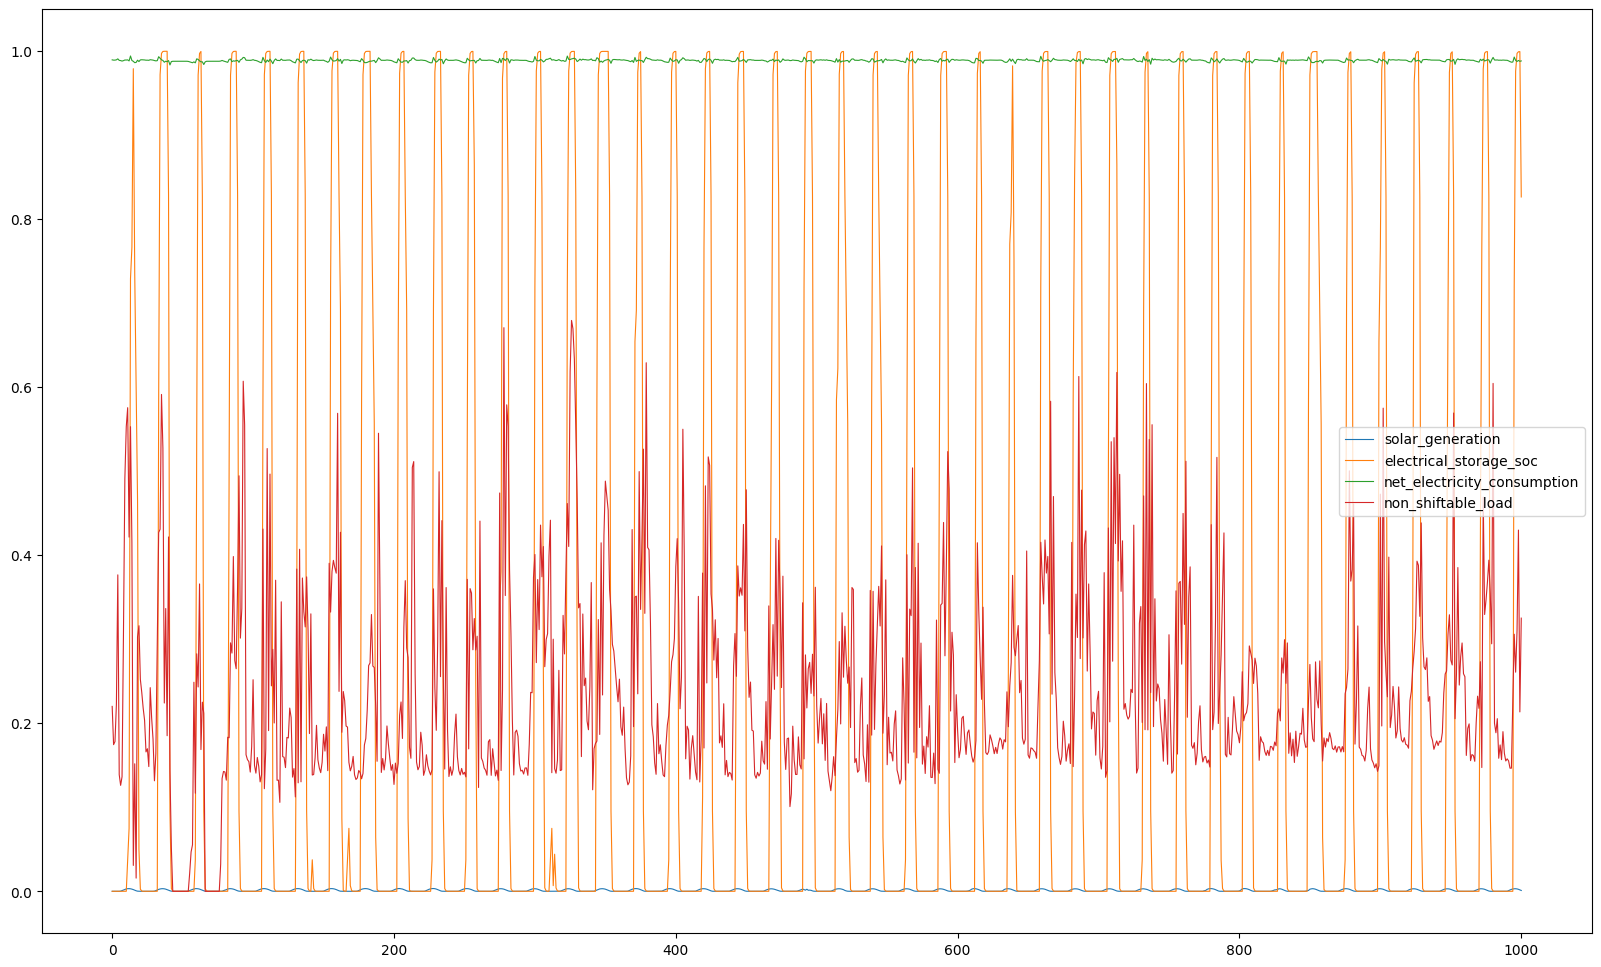

In [30]:
df_adv_obs[[#'outdoor_dry_bulb_temperature',
                 'solar_generation',
                 'electrical_storage_soc',
                 'net_electricity_consumption',
                 'non_shiftable_load',
                 #'electricity_pricing'
                 ]].plot.line(figsize=(20,12), lw=0.8)

We could mask other features where tampering would be obvious e.g. temperture predictions vary between observations, but pricing predictions are identical for many obvservations and vary predictably.

Evaluate agent with variable epsilon:
- Start at min value and increase in loop
- try multiple values in parallel
- return stat on the eps used, box plot?